# Image generation - DCGAN

**GAN (Generative Adversarial Network)** is a machine learning architecture where two neural networks compete against each other: a Generator creates fake data (like images) while a Discriminator tries to distinguish between real and fake data. Through this adversarial training process, the Generator becomes increasingly skilled at creating realistic data that can fool the Discriminator.


**DCGAN (Deep Convolutional GAN)** is an improved version of the basic GAN that uses convolutional layers instead of fully connected layers. This architectural change makes DCGANs much better at generating high-quality images because convolutional layers are specifically designed to understand spatial relationships and visual patterns in image data.

## Import libraries

In [1]:
import os, math, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

## Device and directory setup

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Tue Aug 19 16:52:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
save_dir = 'outputs'
data_dir = 'data'

os.makedirs(save_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

## Data preprocessing

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # normalize to [-1, 1]
])

In [5]:
dataset = datasets.MNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=transform
)

## Hyperparameters

In [6]:
latent_dim = 100
img_channels = 1
img_size = 28
batch_size = 128
epochs = 75
lr_g = 2e-4
lr_d = 1e-4
sample_every = 500
model_checkpoint_every = 50

## Deep Convolutional Generative Adversarial Network (DCGAN)

In [7]:
class Generator(nn.Module):
    def __init__(self, zdim=latent_dim):
        super().__init__()
        self.zdim = zdim

        # Initial dense layer to get to 7x7x256
        self.fc = nn.Sequential(
            nn.Linear(zdim, 7*7*256),
            nn.BatchNorm1d(7*7*256),
            nn.ReLU(True)
        )

        # Convolutional layers
        self.conv = nn.Sequential(
            # 7x7x256 -> 14x14x128
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 14x14x128 -> 28x28x64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 28x28x64 -> 28x28x1
            nn.ConvTranspose2d(64, img_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 7, 7)
        x = self.conv(x)
        return x

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # 28x28x1 -> 14x14x64
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 14x14x64 -> 7x7x128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 7x7x128 -> 1x1x256
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 1),  # Adjusted for the actual output size
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [9]:
# Initialize models
G = Generator().to(device)
D = Discriminator().to(device)

# Initialize weights
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [10]:
G.apply(weights_init)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=True)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [11]:
D.apply(weights_init)

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [12]:
# Data loader
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True  # ensure consistent batch sizes
)

In [13]:
# Loss and optimizers
criterion = nn.BCELoss()
optG = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))
optD = optim.Adam(D.parameters(), lr=lr_d, betas=(0.5, 0.999))

# Learning rate schedulers
schedulerG = optim.lr_scheduler.ExponentialLR(optG, gamma=0.99)
schedulerD = optim.lr_scheduler.ExponentialLR(optD, gamma=0.99)

# Fixed noise for consistent sample generation
fixed_noise = torch.randn(64, latent_dim, device=device)

# Label smoothing parameters
real_label_smooth = 0.9
fake_label_smooth = 0.1

In [14]:
# Training loop
G_losses = []
D_losses = []
step = 0
img_samples = []

print("Starting training...")

for epoch in range(epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", ncols=120)

    for i, (real_imgs, _) in enumerate(pbar):
        real_imgs = real_imgs.to(device)
        bs = real_imgs.size(0)

        # Train Discriminator
        optD.zero_grad()

        # Real images
        real_labels = torch.full((bs, 1), real_label_smooth, device=device)
        real_output = D(real_imgs)
        lossD_real = criterion(real_output, real_labels)

        # Fake images
        noise = torch.randn(bs, latent_dim, device=device)
        fake_imgs = G(noise)
        fake_labels = torch.full((bs, 1), fake_label_smooth, device=device)
        fake_output = D(fake_imgs.detach())
        lossD_fake = criterion(fake_output, fake_labels)

        # Total discriminator loss
        lossD = lossD_real + lossD_fake
        lossD.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=1.0)
        optD.step()

        # Train Generator
        optG.zero_grad()

        # Generator wants discriminator to think fake images are real
        real_labels.fill_(1.0)  # Use hard labels for generator training
        fake_output = D(fake_imgs)
        lossG = criterion(fake_output, real_labels)
        lossG.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(G.parameters(), max_norm=1.0)
        optG.step()

        # Store losses
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        # Update progress bar
        pbar.set_postfix({
            "lossD": f"{lossD.item():.3f}",
            "lossG": f"{lossG.item():.3f}",
            "D(x)": f"{real_output.mean().item():.3f}",
            "D(G(z))": f"{fake_output.mean().item():.3f}"
        })

        # Save sample images
        if step % sample_every == 0:
            with torch.no_grad():
                G.eval()
                samples = G(fixed_noise)
                grid = utils.make_grid(samples, nrow=8, normalize=True, value_range=(-1, 1))
                img_pil = TF.to_pil_image(grid.cpu())
                img_samples.append(img_pil)
                G.train()

        step += 1

    # Update learning rates
    schedulerG.step()
    schedulerD.step()

    # Save model checkpoints
    if (epoch + 1) % model_checkpoint_every == 0 or epoch == epochs - 1:
        torch.save({
            'epoch': epoch,
            'generator_state_dict': G.state_dict(),
            'discriminator_state_dict': D.state_dict(),
            'optG_state_dict': optG.state_dict(),
            'optD_state_dict': optD.state_dict(),
            'G_losses': G_losses,
            'D_losses': D_losses,
        }, f'{save_dir}/checkpoint_epoch_{epoch+1}.pth')

print("Training completed!")

Starting training...


Epoch 75/75: 100%|███████████████| 468/468 [00:18<00:00, 24.96it/s, lossD=0.736, lossG=1.654, D(x)=0.803, D(G(z))=0.217]


Training completed!


In [15]:
def show_sample(index):
    img = img_samples[index]
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Step {index * sample_every}")
    plt.show()

slider = widgets.IntSlider(min=0, max=len(img_samples)-1, step=1, description='Sample')
widgets.interact(show_sample, index=slider)

interactive(children=(IntSlider(value=0, description='Sample', max=70), Output()), _dom_classes=('widget-inter…

<function __main__.show_sample(index)>

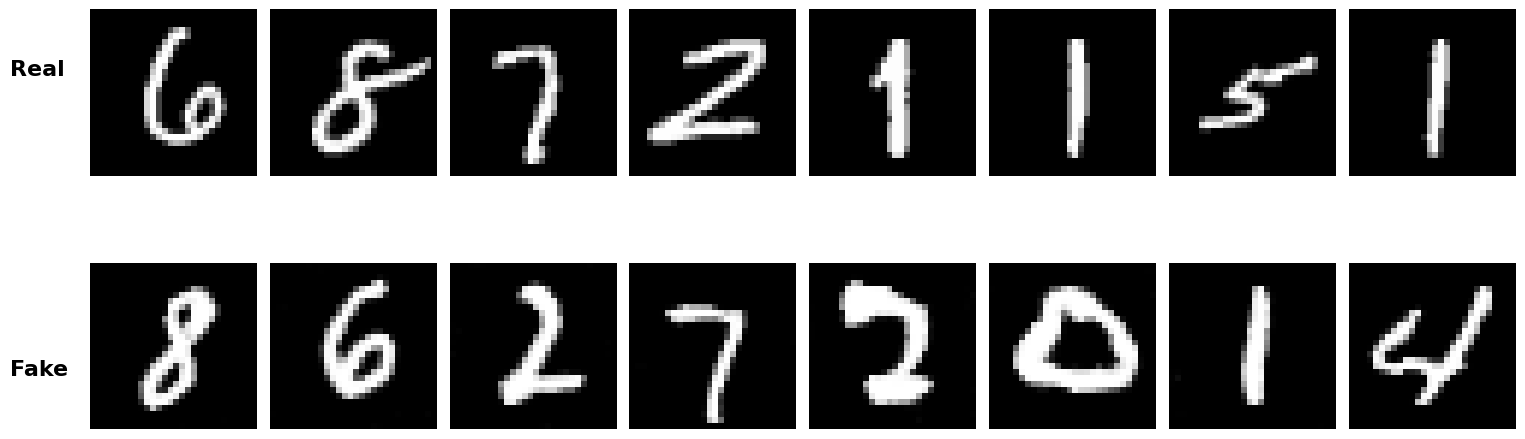

In [20]:
G.eval()
with torch.no_grad():
    # Generate fake samples
    final_noise = torch.randn(64, latent_dim, device=device)
    final_samples = G(final_noise).cpu()

    # Denormalize from [-1, 1] to [0, 1] for display
    final_samples = (final_samples + 1) / 2
    final_samples = final_samples.clamp(0, 1)

    # Get real samples
    real_samples = next(iter(dataloader))[0][:64]
    # Denormalize real samples too
    real_samples = (real_samples + 1) / 2
    real_samples = real_samples.clamp(0, 1)

    # Number of images to display per row
    nrow = 8

    # Create a figure with 2 rows: real and fake
    fig, axes = plt.subplots(2, nrow, figsize=(nrow * 2, 6))

    for j in range(nrow):
        # Top row: real images
        axes[0, j].imshow(real_samples[j].squeeze().numpy(), cmap='gray', interpolation='nearest')
        axes[0, j].axis("off")

        # Bottom row: generated (fake) images
        axes[1, j].imshow(final_samples[j].squeeze().numpy(), cmap='gray', interpolation='nearest')
        axes[1, j].axis("off")

    # Add row labels on the left side
    fig.text(0.05, 0.75, 'Real', fontsize=16, fontweight='bold', va='center')
    fig.text(0.05, 0.25, 'Fake', fontsize=16, fontweight='bold', va='center')

    plt.tight_layout()
    plt.subplots_adjust(left=0.1)
    plt.show()

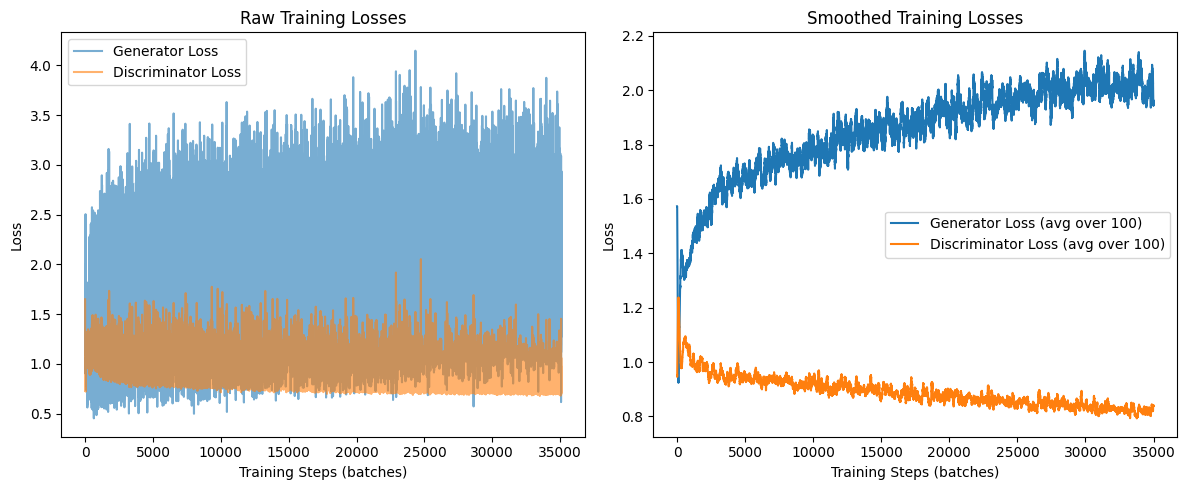

In [23]:
# Compute moving average for smoother curves
def moving_average(values, window):
    return np.convolve(values, np.ones(window)/window, mode='valid')

# Plot training losses
plt.figure(figsize=(12, 5))

# Raw Losses
plt.subplot(1, 2, 1)
plt.plot(G_losses, label='Generator Loss', alpha=0.6)
plt.plot(D_losses, label='Discriminator Loss', alpha=0.6)
plt.xlabel('Training Steps (batches)')
plt.ylabel('Loss')
plt.title('Raw Training Losses')
plt.legend()

# Smoothed Losses
plt.subplot(1, 2, 2)
window = 100  # Moving average window
g_smooth = moving_average(G_losses, window)
d_smooth = moving_average(D_losses, window)

plt.plot(g_smooth, label=f'Generator Loss (avg over {window})')
plt.plot(d_smooth, label=f'Discriminator Loss (avg over {window})')
plt.xlabel('Training Steps (batches)')
plt.ylabel('Loss')
plt.title('Smoothed Training Losses')
plt.legend()

plt.tight_layout()
plt.show()